In [1]:
%pip install mplfinance
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\gwtan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\gwtan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import os
import pandas as pd
import requests
import gzip
import zipfile
import io
from datetime import datetime, timedelta
import tkinter as tk
from tkinter import filedialog, messagebox
from tkcalendar import DateEntry
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np

# Global variables to store parameters from the GUI Slay
download_path = None
chosen_symbol = None
chosen_start_date = None
chosen_end_date = None

# ----------------------------------------------
# Download Functions
# ----------------------------------------------
def download_binance_data(url, output_file, file_type='zip'):
    """Download and extract Binance data from the given URL."""
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        try:
            if file_type == 'zip':
                with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                    name = z.namelist()[0]
                    with z.open(name) as f:
                        df = pd.read_csv(f)
            elif file_type == 'csv':
                with gzip.GzipFile(fileobj=io.BytesIO(response.content), mode='rb') as f:
                    df = pd.read_csv(f)
            else:
                print("Unknown file type specified.")
                return
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            df.to_csv(output_file, index=False)
            print(f"Saved: {output_file}")
        except Exception as e:
            print(f"Error processing {url}: {e}")
    else:
        print(f"Failed to download: {url}")

def generate_binance_urls(symbol, start_date, end_date):
    """Generate URLs for Binance trade and kline data."""
    base_url = "https://data.binance.vision/data/spot/daily/"
    urls = []
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        trade_url = f"{base_url}trades/{symbol}/{symbol}-trades-{date_str}.zip"
        kline_url = f"{base_url}klines/{symbol}/1m/{symbol}-1m-{date_str}.zip"
        urls.append((trade_url, kline_url, date_str))
        current_date += timedelta(days=1)
    return urls

def start_download():
    """Handle the download process when the user clicks the button."""
    global download_path, chosen_symbol, chosen_start_date, chosen_end_date
    symbol = symbol_var.get()
    start_date = datetime.strptime(start_date_entry.get(), "%Y-%m-%d")
    end_date = datetime.strptime(end_date_entry.get(), "%Y-%m-%d")
    chosen_symbol = symbol
    chosen_start_date = start_date
    chosen_end_date = end_date

    output_folder = filedialog.askdirectory()
    if not output_folder:
        messagebox.showerror("Error", "Please select an output folder.")
        return

    urls = generate_binance_urls(symbol, start_date, end_date)
    for trade_url, kline_url, date_str in urls:
        trade_file = os.path.join(output_folder, f"{symbol}-trades-{date_str}.csv")
        kline_file = os.path.join(output_folder, f"{symbol}-klines-1m-{date_str}.csv")
        download_binance_data(trade_url, trade_file, file_type='zip')
        download_binance_data(kline_url, kline_file, file_type='zip')

    download_path = output_folder
    messagebox.showinfo("Success", f"Download complete!\nFiles saved to: {download_path}")
    root.destroy()

# ----------------------------------------------
# GUI Setup for Download
# ----------------------------------------------
root = tk.Tk()
root.title("Binance Data Downloader")

symbol_var = tk.StringVar(value="ETHUSDT")

tk.Label(root, text="Select Symbol:").grid(row=0, column=0)
tk.OptionMenu(root, symbol_var, "ETHUSDT", "BTCUSDT").grid(row=0, column=1)

tk.Label(root, text="Start Date:").grid(row=1, column=0)
start_date_entry = DateEntry(root, width=12, background='darkblue', foreground='white', date_pattern='yyyy-MM-dd')
start_date_entry.grid(row=1, column=1)

tk.Label(root, text="End Date:").grid(row=2, column=0)
end_date_entry = DateEntry(root, width=12, background='darkblue', foreground='white', date_pattern='yyyy-MM-dd')
end_date_entry.grid(row=2, column=1)

download_button = tk.Button(root, text="Download Data", command=start_download)
download_button.grid(row=3, columnspan=2)

root.mainloop()

Saved: C:/Users/gwtan/OneDrive/Documents/For Repository Slay\BTCUSDT-trades-2025-02-12.csv
Saved: C:/Users/gwtan/OneDrive/Documents/For Repository Slay\BTCUSDT-klines-1m-2025-02-12.csv


In [3]:
# ----------------------------------------------
# Data Loading and Analysis Functions
# ----------------------------------------------
def load_binance_data(output_folder, symbol, start_date, end_date):
    """
    Load trade and kline data from downloaded CSV files (without headers)
    and assign the proper column names.
    """
    trade_files = []
    kline_files = []

    # Define headers for CSV files with no header row
    trade_columns = ["tradeId", "price", "qty", "quoteQty", "time", "isBuyerMaker", "isBestMatch"]
    kline_columns = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
    ]

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        trade_file_path = os.path.join(output_folder, f"{symbol}-trades-{date_str}.csv")
        kline_file_path = os.path.join(output_folder, f"{symbol}-klines-1m-{date_str}.csv")
        print("Checking for file:", trade_file_path)
        print("Checking for file:", kline_file_path)
        if os.path.exists(trade_file_path):
            df_trade = pd.read_csv(trade_file_path, header=None, names=trade_columns)
            trade_files.append(df_trade)
        if os.path.exists(kline_file_path):
            df_kline = pd.read_csv(kline_file_path, header=None, names=kline_columns)
            # Convert the open_time (ms) to a datetime column
            df_kline['datetime'] = pd.to_datetime(df_kline['open_time'], unit='us')
            kline_files.append(df_kline)
        current_date += timedelta(days=1)

    if trade_files:
        trade_df = pd.concat(trade_files, ignore_index=True)
        trade_df['datetime'] = pd.to_datetime(trade_df['time'], unit='us')
    else:
        trade_df = pd.DataFrame()

    if kline_files:
        kline_df = pd.concat(kline_files, ignore_index=True)
    else:
        kline_df = pd.DataFrame()

    return trade_df, kline_df

def plot_candlestick(kline_df, title="Candlestick Chart"):
    """
    Create a candlestick chart from kline data.
    Expects kline_df to have a 'datetime' column plus 'open', 'high', 'low', 'close', and 'volume' columns.
    """
    df = kline_df.copy()
    if 'datetime' not in df.columns:
        print("No datetime column in kline_df.")
        return
    df.set_index('datetime', inplace=True)
    # Convert columns to numeric, coercing errors to NaN
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Only keep the columns we need
    df = df[['open', 'high', 'low', 'close', 'volume']]
    # Drop rows with missing values in OHLC columns
    df.dropna(subset=['open', 'high', 'low', 'close'], inplace=True)
    mpf.plot(df, type='candle', style='charles', title=title, volume=True)

Loading data from: C:/Users/gwtan/OneDrive/Documents/For Repository Slay
Checking for file: C:/Users/gwtan/OneDrive/Documents/For Repository Slay\BTCUSDT-trades-2025-02-12.csv
Checking for file: C:/Users/gwtan/OneDrive/Documents/For Repository Slay\BTCUSDT-klines-1m-2025-02-12.csv
Displaying candlestick chart...


C:\Users\gwtan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


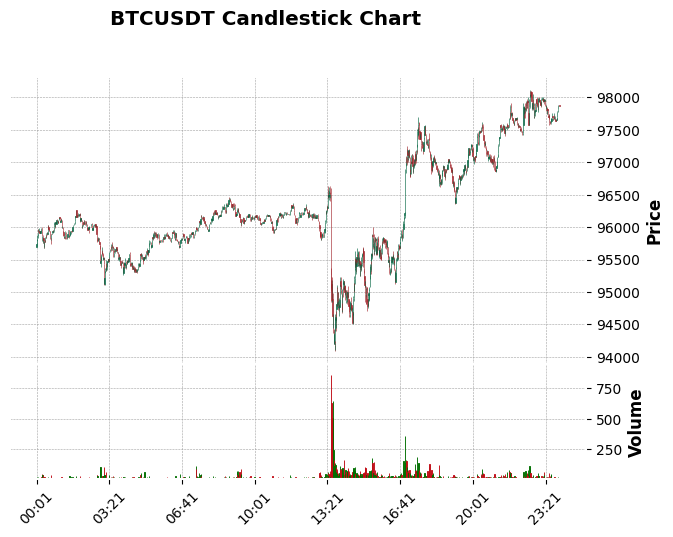

Perpetual Effect Analysis:
    threshold  avg_price_change  n_orders
0   1000000.0         -0.003524         9
1   5000000.0               NaN         0
2  10000000.0               NaN         0

Instant Effect Analysis:
    threshold  avg_instant_price_change  n_orders
0   1000000.0                 -0.000208         9
1   5000000.0                       NaN         0
2  10000000.0                       NaN         0

Effect Duration Analysis:
{1: -0.0010442438092510425, 5: -0.0020328971820822326, 10: -0.0035235916948466012, 30: -0.0018211491793984655, 60: -0.001976779487522299}


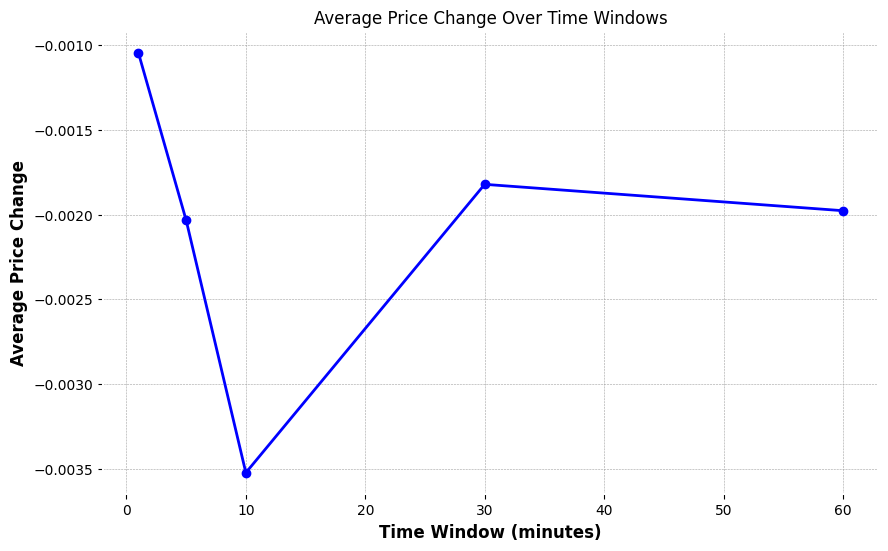


Price and Volume Effect Analysis:
    threshold  avg_price_change  avg_cumulative_volume  n_orders
0   1000000.0         -0.003524            1286.362669         9
1   5000000.0               NaN                    NaN         0
2  10000000.0               NaN                    NaN         0


In [4]:
# -------------------------------
# Analysis Functions
# -------------------------------
def compute_price_change(order_time, kline_df, window_minutes=10):
    window_end = order_time + timedelta(minutes=window_minutes)
    try:
        base_price = kline_df.loc[kline_df['datetime'] >= order_time, 'close'].iloc[0]
        future_price = kline_df.loc[kline_df['datetime'] >= window_end, 'close'].iloc[0]
        return (future_price - base_price) / base_price
    except Exception as e:
        return np.nan

def compute_cumulative_volume(order_time, kline_df, window_minutes=10):
    """
    Compute the cumulative trading volume over a time window starting at order_time.
    """
    window_end = order_time + timedelta(minutes=window_minutes)
    try:
        # Filter the rows between order_time and window_end
        mask = (kline_df['datetime'] >= order_time) & (kline_df['datetime'] < window_end)
        cum_volume = kline_df.loc[mask, 'volume'].astype(float).sum()
        return cum_volume
    except Exception as e:
        return np.nan

def analyze_order_effect(trade_df, kline_df, thresholds=[1e6, 5e6, 10e6], window_minutes=10):
    results = []
    for threshold in thresholds:
        subset = trade_df[trade_df['quoteQty'] >= threshold]
        price_changes = []
        for _, row in subset.iterrows():
            # Use the precomputed datetime column
            order_time = row['datetime']
            change = compute_price_change(order_time, kline_df, window_minutes)
            if not np.isnan(change):
                price_changes.append(change)
        avg_change = np.mean(price_changes) if price_changes else np.nan
        results.append({
            'threshold': threshold,
            'avg_price_change': avg_change,
            'n_orders': len(price_changes)
        })
    return pd.DataFrame(results)

def analyze_instant_effect(trade_df, kline_df, thresholds=[1e6, 5e6, 10e6], window_seconds=30):
    results = []
    window_minutes = window_seconds / 60.0
    for threshold in thresholds:
        subset = trade_df[trade_df['quoteQty'] >= threshold]
        price_changes = []
        for _, row in subset.iterrows():
            order_time = row['datetime']
            change = compute_price_change(order_time, kline_df, window_minutes)
            if not np.isnan(change):
                price_changes.append(change)
        avg_change = np.mean(price_changes) if price_changes else np.nan
        results.append({
            'threshold': threshold,
            'avg_instant_price_change': avg_change,
            'n_orders': len(price_changes)
        })
    return pd.DataFrame(results)

def analyze_effect_duration(trade_df, kline_df, threshold=1e6, time_windows=[1, 5, 10, 30, 60]):
    subset = trade_df[trade_df['quoteQty'] >= threshold]
    duration_effects = {w: [] for w in time_windows}
    for _, row in subset.iterrows():
        order_time = row['datetime']
        for w in time_windows:
            change = compute_price_change(order_time, kline_df, window_minutes=w)
            if not np.isnan(change):
                duration_effects[w].append(change)
    avg_effects = {w: np.mean(duration_effects[w]) if duration_effects[w] else np.nan for w in time_windows}
    return avg_effects

def analyze_price_volume_effect(trade_df, kline_df, thresholds=[1e6, 5e6, 10e6], window_minutes=10):
    results = []
    for threshold in thresholds:
        subset = trade_df[trade_df['quoteQty'] >= threshold]
        price_changes = []
        cum_volumes = []
        for _, row in subset.iterrows():
            order_time = row['datetime']
            p_change = compute_price_change(order_time, kline_df, window_minutes)
            c_volume = compute_cumulative_volume(order_time, kline_df, window_minutes)
            if not np.isnan(p_change) and not np.isnan(c_volume):
                price_changes.append(p_change)
                cum_volumes.append(c_volume)
        avg_price_change = np.mean(price_changes) if price_changes else np.nan
        avg_cum_volume = np.mean(cum_volumes) if cum_volumes else np.nan
        results.append({
            'threshold': threshold,
            'avg_price_change': avg_price_change,
            'avg_cumulative_volume': avg_cum_volume,
            'n_orders': len(price_changes)
        })
    return pd.DataFrame(results)

def plot_effect_duration(avg_effects):
    """
    Plot the average price change over different time windows.
    
    Parameters:
    avg_effects (dict): Dictionary where keys are time windows (in minutes) and 
                        values are the corresponding average price changes.
    """
    time_windows = list(avg_effects.keys())
    avg_changes = list(avg_effects.values())

    plt.figure(figsize=(10, 6))
    plt.plot(time_windows, avg_changes, marker='o', linestyle='-', color='b')
    plt.title('Average Price Change Over Time Windows')
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('Average Price Change')
    plt.grid(True)
    plt.show()

# ----------------------------------------------
# Main Execution Block for Analysis
# ----------------------------------------------
if __name__ == '__main__':
    # Ensure that the GUI has finished and the global variables are set
    if not download_path:
        print("No download path stored. Exiting analysis.")
    else:
        print("Loading data from:", download_path)
        trade_df, kline_df = load_binance_data(download_path, chosen_symbol, chosen_start_date, chosen_end_date)
        
        if trade_df.empty or kline_df.empty:
            print("Data not loaded. Please check your CSV files in", download_path)
        else:
            print("Displaying candlestick chart...")
            plot_candlestick(kline_df, title=f"{chosen_symbol} Candlestick Chart")
            
            effect_df = analyze_order_effect(trade_df, kline_df)
            print("Perpetual Effect Analysis:")
            print(effect_df)
            
            instant_effect_df = analyze_instant_effect(trade_df, kline_df)
            print("\nInstant Effect Analysis:")
            print(instant_effect_df)
            
            avg_effects = analyze_effect_duration(trade_df, kline_df)
            print("\nEffect Duration Analysis:")
            print(avg_effects)
            plot_effect_duration(avg_effects)
            
            price_volume_df = analyze_price_volume_effect(trade_df, kline_df)
            print("\nPrice and Volume Effect Analysis:")
            print(price_volume_df)

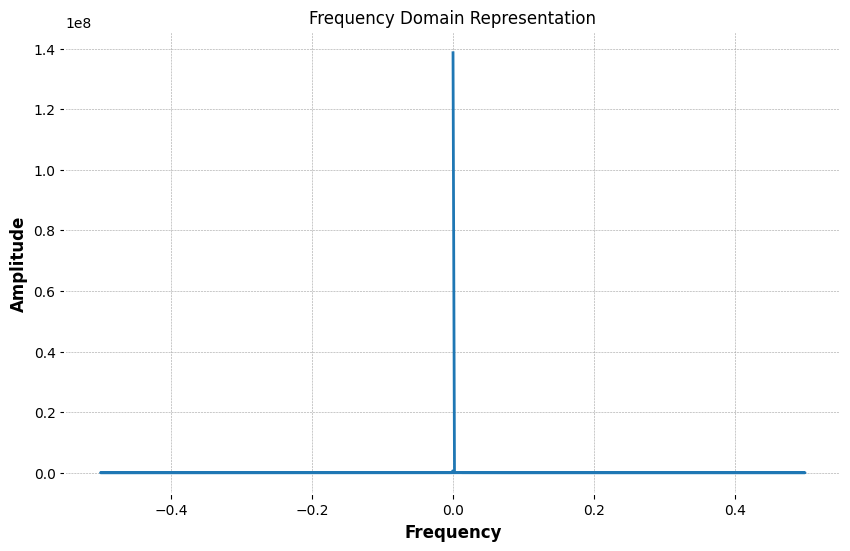

In [5]:
# Assuming 'close' prices are in kline_df
close_prices = kline_df['close'].values

# Apply Fourier Transform
fft_values = np.fft.fft(close_prices)
frequencies = np.fft.fftfreq(len(fft_values))

# Plotting the amplitude spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_values))
plt.title('Frequency Domain Representation')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

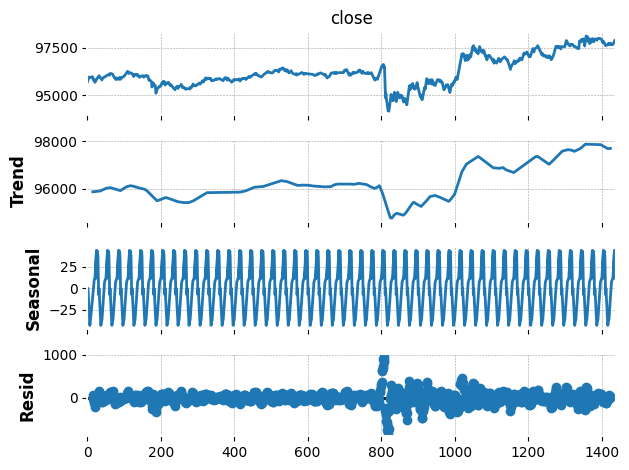

In [6]:
import statsmodels.api as sm

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(kline_df['close'], model='additive', period=30)
kline_df['trend'] = decomposition.trend
kline_df['seasonal'] = decomposition.seasonal
kline_df['residual'] = decomposition.resid

# Plotting the decomposition
decomposition.plot()
plt.show()


C:\Users\gwtan\AppData\Local\Temp\ipykernel_9256\695453865.py:205: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'time': pd.date_range(start='2023-01-01', periods=100, freq='T').astype(np.int64) // 10**6,
C:\Users\gwtan\AppData\Local\Temp\ipykernel_9256\695453865.py:211: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'datetime': pd.date_range(start='2023-01-01', periods=1440, freq='T'),


Big order frequency: 0.8


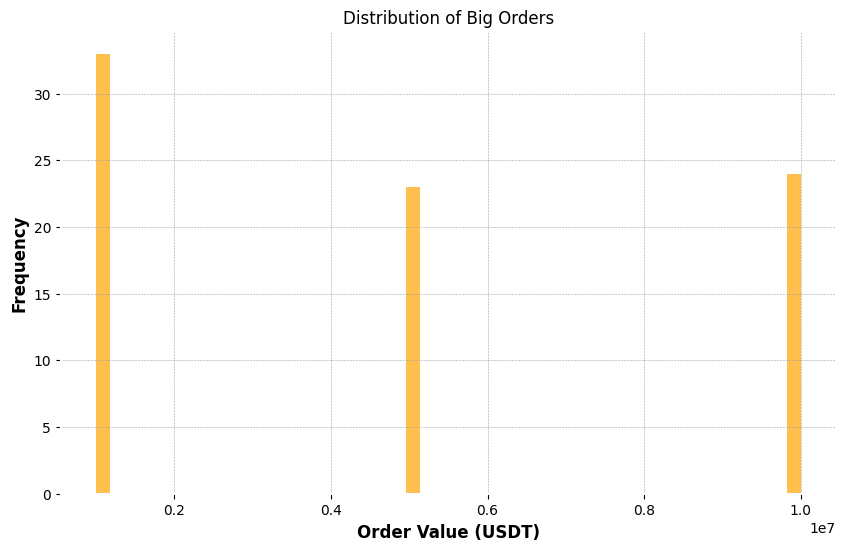

Perpetual Effects:
     threshold  avg_price_change  n_orders
0   1000000.0          0.012773        80
1   5000000.0         -0.000405        47
2  10000000.0          0.010119        24
Instantaneous Impact:
     threshold  avg_instant_price_change  n_orders
0   1000000.0                  0.016233        80
1   5000000.0                  0.016494        47
2  10000000.0                  0.015245        24
Duration Effects:
 {1: 0.01623333250121672, 5: 0.011918933037848762, 10: 0.012772586310387756, 30: 0.0006684468827519261, 60: -0.00017982299477555045}


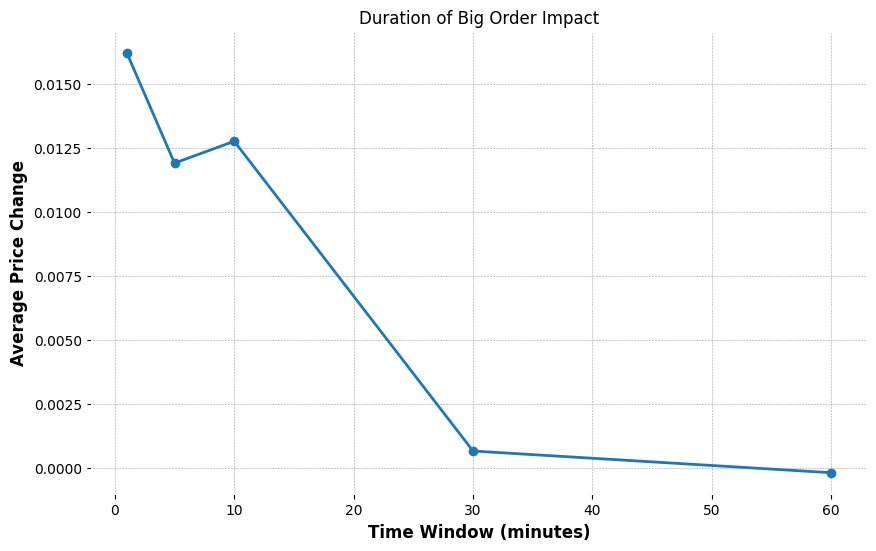

Price and Volume Correlation:
 {'threshold': 1000000.0, 'avg_price_change': 0.012772586310387756, 'avg_volume': 1244.6367144259116, 'correlation': 0.07692960850837076, 'n_orders': 80}
Daily Aggregated Impact:
          date  n_big_orders  avg_price_change   avg_volume
0  2023-01-01            80          0.012773  1244.636714


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# -------------------------------
# Helper Functions
# -------------------------------
def compute_price_change(kline_df, start_time, window_minutes):
    """
    Compute the percentage price change from start_time to start_time+window_minutes.
    """
    window_end = start_time + timedelta(minutes=window_minutes)
    # Get the first available price at or after start_time and window_end
    base_row = kline_df[kline_df['datetime'] >= start_time].head(1)
    future_row = kline_df[kline_df['datetime'] >= window_end].head(1)
    if base_row.empty or future_row.empty:
        return np.nan
    base_price = base_row.iloc[0]['close']
    future_price = future_row.iloc[0]['close']
    return (future_price - base_price) / base_price

def compute_volume_sum(kline_df, start_time, window_minutes):
    """
    Compute cumulative trading volume between start_time and start_time+window_minutes.
    """
    window_end = start_time + timedelta(minutes=window_minutes)
    subset = kline_df[(kline_df['datetime'] >= start_time) & (kline_df['datetime'] < window_end)]
    return subset['volume'].sum() if not subset.empty else np.nan

# -------------------------------
# 1. Influence of Big Orders
#    a. Market Sentiment and Momentum
# -------------------------------
def big_order_sentiment(trade_df, threshold):
    """
    Calculates the frequency of big orders relative to all orders and extracts these orders.
    """
    big_orders = trade_df[trade_df['quoteQty'] >= threshold]
    frequency = len(big_orders) / len(trade_df) if len(trade_df) > 0 else 0
    return frequency, big_orders

def plot_big_order_distribution(trade_df, threshold):
    """
    Plots the distribution of order sizes above a certain threshold.
    """
    big_orders = trade_df[trade_df['quoteQty'] >= threshold]
    plt.figure(figsize=(10, 6))
    plt.hist(big_orders['quoteQty'], bins=50, alpha=0.7, color='orange')
    plt.xlabel('Order Value (USDT)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Big Orders')
    plt.show()

# -------------------------------
# 2. Transaction Amount and Perpetual Effects
#    a. Trend Persistence and Risk Management
# -------------------------------
def analyze_perpetual_effects(trade_df, kline_df, thresholds=[1e6, 5e6, 10e6], window_minutes=10):
    """
    For each threshold, compute the average price change after big orders over a given window.
    This helps indicate if the market tends to revert or continue in a trend.
    """
    results = []
    for threshold in thresholds:
        orders = trade_df[trade_df['quoteQty'] >= threshold]
        changes = []
        for _, order in orders.iterrows():
            order_time = order['datetime']
            price_change = compute_price_change(kline_df, order_time, window_minutes)
            if not np.isnan(price_change):
                changes.append(price_change)
        avg_change = np.mean(changes) if changes else np.nan
        results.append({'threshold': threshold, 'avg_price_change': avg_change, 'n_orders': len(changes)})
    return pd.DataFrame(results)

# -------------------------------
# 3. Instantaneous Impact Analysis
#    a. Short-term Volatility and Algorithmic Tuning
# -------------------------------
def analyze_instant_impact(trade_df, kline_df, thresholds=[1e6, 5e6, 10e6], window_seconds=30):
    """
    For each threshold, calculate the immediate price change (using a short window in seconds).
    This is useful for high-frequency trading strategies.
    """
    results = []
    window_minutes = window_seconds / 60.0
    for threshold in thresholds:
        orders = trade_df[trade_df['quoteQty'] >= threshold]
        changes = []
        for _, order in orders.iterrows():
            order_time = order['datetime']
            price_change = compute_price_change(kline_df, order_time, window_minutes)
            if not np.isnan(price_change):
                changes.append(price_change)
        avg_change = np.mean(changes) if changes else np.nan
        results.append({'threshold': threshold, 'avg_instant_price_change': avg_change, 'n_orders': len(changes)})
    return pd.DataFrame(results)

# -------------------------------
# 4. Timed Effect and Duration Analysis
#    a. Duration of Market Impact and Influential Factors
# -------------------------------
def analyze_duration_effect(trade_df, kline_df, threshold=1e6, time_windows=[1, 5, 10, 30, 60]):
    """
    For orders above a given threshold, compute the average price change over multiple time windows.
    This creates a decay or persistence curve for the impact of big orders.
    """
    orders = trade_df[trade_df['quoteQty'] >= threshold]
    duration_results = {w: [] for w in time_windows}
    for _, order in orders.iterrows():
        order_time = order['datetime']
        for w in time_windows:
            price_change = compute_price_change(kline_df, order_time, w)
            if not np.isnan(price_change):
                duration_results[w].append(price_change)
    avg_effects = {w: np.mean(duration_results[w]) if duration_results[w] else np.nan for w in time_windows}
    return avg_effects

def plot_duration_effect(avg_effects):
    """
    Plot the average price change vs. time window to visualize how long the effect lasts.
    """
    windows = list(avg_effects.keys())
    effects = list(avg_effects.values())
    plt.figure(figsize=(10, 6))
    plt.plot(windows, effects, marker='o')
    plt.xlabel('Time Window (minutes)')
    plt.ylabel('Average Price Change')
    plt.title('Duration of Big Order Impact')
    plt.grid(True)
    plt.show()

# -------------------------------
# 5. Price and Trading Volume Correlation
#    a. Signal Confirmation and Liquidity Insights
# -------------------------------
def analyze_price_volume_correlation(trade_df, kline_df, threshold=1e6, window_minutes=10):
    """
    For orders above a threshold, compute both the average price change and the cumulative trading volume,
    then compute the correlation between them.
    """
    orders = trade_df[trade_df['quoteQty'] >= threshold]
    price_changes = []
    volumes = []
    for _, order in orders.iterrows():
        order_time = order['datetime']
        price_change = compute_price_change(kline_df, order_time, window_minutes)
        volume = compute_volume_sum(kline_df, order_time, window_minutes)
        if not np.isnan(price_change) and not np.isnan(volume):
            price_changes.append(price_change)
            volumes.append(volume)
    avg_price_change = np.mean(price_changes) if price_changes else np.nan
    avg_volume = np.mean(volumes) if volumes else np.nan
    correlation = np.corrcoef(price_changes, volumes)[0, 1] if len(price_changes) > 1 else np.nan
    return {
        'threshold': threshold,
        'avg_price_change': avg_price_change,
        'avg_volume': avg_volume,
        'correlation': correlation,
        'n_orders': len(price_changes)
    }

# -------------------------------
# 6. Daily Aggregated Impact
#    a. Macro Trends Identification and Strategic Allocation
# -------------------------------
def daily_aggregated_impact(trade_df, kline_df, threshold=1e6, window_minutes=10):
    """
    Aggregates the effects of big orders on a daily basis.
    It calculates the number of big orders, average price change, and average volume for each day.
    """
    # Ensure there is a 'date' column in trade_df
    trade_df['date'] = trade_df['datetime'].dt.date
    daily_stats = []
    grouped = trade_df[trade_df['quoteQty'] >= threshold].groupby('date')
    for date, group in grouped:
        price_changes = []
        volumes = []
        for _, order in group.iterrows():
            order_time = order['datetime']
            price_change = compute_price_change(kline_df, order_time, window_minutes)
            volume = compute_volume_sum(kline_df, order_time, window_minutes)
            if not np.isnan(price_change) and not np.isnan(volume):
                price_changes.append(price_change)
                volumes.append(volume)
        daily_stats.append({
            'date': date,
            'n_big_orders': len(group),
            'avg_price_change': np.mean(price_changes) if price_changes else np.nan,
            'avg_volume': np.mean(volumes) if volumes else np.nan
        })
    return pd.DataFrame(daily_stats)

# -------------------------------
# Example Usage
# -------------------------------
if __name__ == '__main__':
    # Assume trade_df and kline_df are loaded from your CSV files and have been preprocessed.
    # For example, trade_df should have columns "time" (in ms) and "quoteQty", and a "datetime" column.
    # kline_df should have columns "datetime", "close", and "volume".
    
    # For demonstration, we create dummy data:
    trade_df = pd.DataFrame({
        'time': pd.date_range(start='2023-01-01', periods=100, freq='T').astype(np.int64) // 10**6,
        'quoteQty': np.random.choice([5e5, 1e6, 5e6, 10e6], 100)
    })
    trade_df['datetime'] = pd.to_datetime(trade_df['time'], unit='ms')
    
    kline_df = pd.DataFrame({
        'datetime': pd.date_range(start='2023-01-01', periods=1440, freq='T'),
        'close': np.random.uniform(30000, 40000, 1440),
        'volume': np.random.uniform(50, 200, 1440)
    })
    
    # 1. Influence of Big Orders: Market Sentiment and Momentum
    freq, big_orders = big_order_sentiment(trade_df, threshold=1e6)
    print("Big order frequency:", freq)
    plot_big_order_distribution(trade_df, threshold=1e6)
    
    # 2. Transaction Amount and Perpetual Effects
    perpetual_effects_df = analyze_perpetual_effects(trade_df, kline_df, thresholds=[1e6, 5e6, 10e6], window_minutes=10)
    print("Perpetual Effects:\n", perpetual_effects_df)
    
    # 3. Instantaneous Impact Analysis
    instant_impact_df = analyze_instant_impact(trade_df, kline_df, thresholds=[1e6, 5e6, 10e6], window_seconds=30)
    print("Instantaneous Impact:\n", instant_impact_df)
    
    # 4. Timed Effect and Duration Analysis
    duration_effects = analyze_duration_effect(trade_df, kline_df, threshold=1e6, time_windows=[1, 5, 10, 30, 60])
    print("Duration Effects:\n", duration_effects)
    plot_duration_effect(duration_effects)
    
    # 5. Price and Trading Volume Correlation
    pv_corr = analyze_price_volume_correlation(trade_df, kline_df, threshold=1e6, window_minutes=10)
    print("Price and Volume Correlation:\n", pv_corr)
    
    # 6. Daily Aggregated Impact
    daily_impact_df = daily_aggregated_impact(trade_df, kline_df, threshold=1e6, window_minutes=10)
    print("Daily Aggregated Impact:\n", daily_impact_df)
